# Maximum Independent Set Using Rydberg Atom Arrays Simulations
[Written by Daniel Turyansky](mailto:daniel.turyansky@mail.huji.ac.il)

**_NOTE:_** This was written using Hannes Pichler's article Quantum Optimization for Maximum Independent Set Using Rydberg Atom Arrays

## Abstract - taken from the article 
We describe and analyze an architecture for quantum optimization to solve maximum independent set (MIS) 
problems using neutral atom arrays trapped in optical tweezers. Optimizing independent sets is one of
 the paradigmatic, NP-hard problems in computer science. Our approach is based on coherent manipulation
  of atom arrays via the excitation into Rydberg atomic states. Specif- ically, we show that solutions
  of MIS problems can be efficiently encoded in the ground state of interacting atoms in 2D arrays by
  utilizing the Rydberg blockade mechanism. By studying the performance of leading classical algorithms,
   we identify parameter regimes, where computationally hard instances can be tested using near-term 
   experimental systems. Practical implementations of both quantum annealing and variational quantum
    optimization algorithms beyond the adiabatic principle are discussed.

## Librarys used

In [6]:

import numpy as np
import matplotlib.pyplot as plt
# The library for quantum adiabatic simulations.
from qutip import * 
# The library used for the graph representation.  
import networkx as nx

## Constants

### Defining usefull matrixs  

$$
\sigma_x = \begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix} , \sigma_y = \begin{pmatrix}
0 & -i \\
i & 0
\end{pmatrix} , \sigma_z = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
 , 
|0\rangle = \begin{pmatrix} 1 \\ 0 \end{pmatrix}
, |1\rangle  = \begin{pmatrix} 0 \\ 1 \end{pmatrix}
$$


In [7]:
# System size - number of qubits
N = 5

# Useful matrices
zero = basis(2, 0)
one = basis(2, 1)
si = qeye(2)

# Define the operators to apply
operators = {'sx': sigmax(), 'sz': sigmaz(), 'one': one * one.dag()}

# Initialize a dictionary to store the lists for each operator
op_lists = {key: [] for key in operators}

# Loop over qubits and operators
for n in range(N):
    for key, op in operators.items():
        op_lists[key].append(tensor([op if m == n else si for m in range(N)]))

# Access the lists
sx_list = op_lists['sx']
sz_list = op_lists['sz']
one_list = op_lists['one']

### Initial Hamiltonian parameters

Using page 4 of the article, we know the detuning ($\Delta(t)$) ,rabi frequency ($\Omega(t)$) and the rabi blockade radius($r_B$). 
$$\Delta(t) = \Delta_0 (2t/T-1)  $$
 $$ \Omega(t) = \Omega_0 sin^2(\pi t/T)$$
$$r_B = C/\sqrt{(2\Omega)^2+\Delta^2}$$

Where C is the interuction strength of rydberg atoms. We also use $\Omega_0 = 1$ and $\Delta_0/\Omega_0 = 6$.

To get the scale of the required T to finish the adiabatic transformation, we can look at different finish times:  
$$T = 5/\Omega_0 , 10/\Omega_0 ,\dots$$

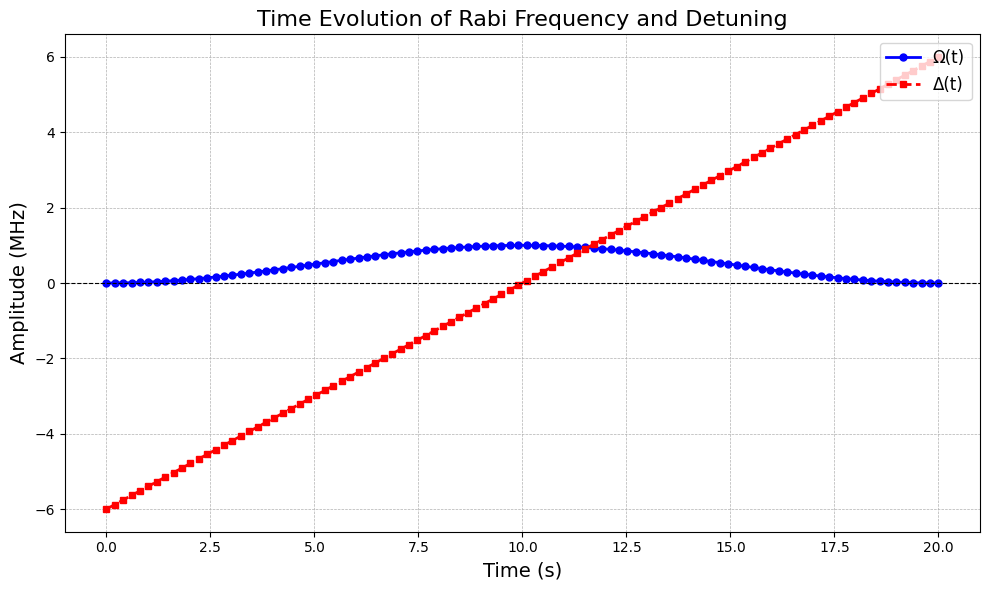

Blockade Radius: 1.0526
Number of Time Points: 100


In [8]:
# Constants and System Parameters
TWO_PI = 2 * np.pi  # Useful for MHz
OMEGA_0 = 1  # Base Rabi frequency
DELTA_0 = 6 / OMEGA_0  # Initial detuning
TAU_MAX = 140 / OMEGA_0  # Maximum time (in units of OMEGA_0)
INTERACTION_STRENGTH = 8.6 * OMEGA_0  # Interaction strength constant
taulist = np.linspace(0, TAU_MAX, 100)  # Time points for plotting

# Calculate blockade radius
blockade_radius = round((INTERACTION_STRENGTH / np.sqrt((2 * OMEGA_0) ** 2 + DELTA_0 ** 2)) ** (1 / 6),10)

# Arguments for time-dependent functions
args = {"t_max": max(taulist)}

# Time-dependent Rabi frequency (Ω) as a lambda function
Omega = lambda t, args: OMEGA_0 * np.sin(np.pi * t / args["t_max"]) ** 2

# Time-dependent detuning (Δ) as a lambda function
def Delta(t,args):
    return DELTA_0 * (2 * t/args["t_max"] -1) 

plt.figure(figsize=(10, 6))

# Plotting the time evolution of Ω(t) and Δ(t)
plt.plot(taulist, Omega(taulist, args), 
         label='Ω(t)', color='blue', linewidth=2, linestyle='-', marker='o', markersize=5)
plt.plot(taulist, Delta(taulist, args), 
         label='Δ(t)', color='red', linewidth=2, linestyle='--', marker='s', markersize=5)

# Adding enhancements to the plot
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude (MHz)', fontsize=14)
plt.title('Time Evolution of Rabi Frequency and Detuning', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0

# Show the plot
plt.tight_layout()
plt.show()

# Output the blockade radius and length of time points
print(f"Blockade Radius: {blockade_radius:.4f}")
print(f"Number of Time Points: {len(taulist)}")

In [9]:
psi_list = [basis(2, 0) for n in range(N)]
psi0 = tensor(psi_list)

## Hamiltonian Construction and Adjacency Matrix for Rydberg Atoms

This code segment initializes and calculates the Hamiltonian for a system of \(N\) Rydberg atoms arranged in a two-dimensional space. 
$$H_{int} = \sum_{v<w} C/x^6(|\vec{x}_v-\vec{x}_w|)n_vn_w$$

In [10]:
# Density of atoms
RHO = 2
# Calculate the side length L of the square region
L = np.sqrt(N/RHO)

# matrix:
adjacency_matrix = np.zeros((N,N))
H_tot = 0

x = [i*blockade_radius for i in range(N)]
y = [0 for i in range(N)]

H_int = 0
for v in range(N):
    H_tot-= one_list[v] 
    for w in range(N):
        if v != w :
            # Calculate the distance between atoms
            dist_x = x[v]-x[w]
            dist_y = y[v]-y[w]
            dist = np.sqrt(dist_x**2+dist_y**2)
            dist = round(dist, 10)
            # Add interaction term to the Hamiltonian
            H_int += 0.5* INTERACTION_STRENGTH / (dist**6) *one_list[v] *  one_list[w]
            # Update adjacency matrix based on distance
            if dist<=blockade_radius:
                adjacency_matrix[w,v] = 1
            if dist>blockade_radius:
                adjacency_matrix[w,v] = 0

adjacency_matrix

array([[0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0.]])

## Calculating independent sets

In [11]:
def is_independent_set(candidate, adjacency_matrix):
    for i in candidate:
        for j in candidate:
            if i != j and adjacency_matrix[i][j] == 1:
                return False
    return True

def backtrack(adjacency_matrix, current_set, remaining_vertices, all_independent_sets):
    if len(remaining_vertices) == 0:
        all_independent_sets.append(current_set.copy())
        return

    vertex = remaining_vertices.pop()
    current_set.add(vertex)
    if is_independent_set(current_set, adjacency_matrix):
        backtrack(adjacency_matrix, current_set, remaining_vertices, all_independent_sets)
    current_set.remove(vertex)
    backtrack(adjacency_matrix, current_set, remaining_vertices, all_independent_sets)
    remaining_vertices.add(vertex)

def find_all_independent_sets(adjacency_matrix):
    all_independent_sets = []
    num_vertices = len(adjacency_matrix)
    remaining_vertices = set(range(num_vertices))

    current_set = set()
    backtrack(adjacency_matrix, current_set, remaining_vertices, all_independent_sets)

    return all_independent_sets


# Find all independent sets
all_independent_sets = find_all_independent_sets(adjacency_matrix)
print("All independent sets:")
for independent_set in all_independent_sets:
    print(independent_set)
    
len(all_independent_sets)

All independent sets:
{0, 2, 4}
{0, 2}
{0, 3}
{0, 4}
{0}
{1, 3}
{1, 4}
{1}
{2, 4}
{2}
{3}
{4}
set()


13

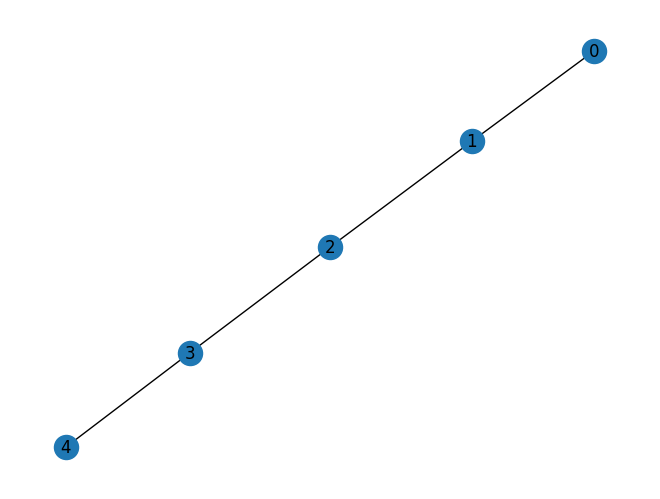

In [18]:

# # Create a graph object
G = nx.Graph()

#Add edges to the graph based on the adjacency matrix
num_nodes = len(adjacency_matrix)
for i in range(num_nodes):
    for j in range(i+1, num_nodes):
        if adjacency_matrix[i][j] == 1:
            G.add_edge(i, j)

# Plot the graph
nx.draw(G, with_labels=True)
plt.show()
G_ = nx.complement(G)
maximal_cliques = list(nx.find_cliques(G_))


##  Hamiltonian Construction for Independent Sets
This code segment performs operations related to converting a list of indices representing independent sets into binary strings and calculating Hamiltonian-like matrices based on these binary representations.

Still need to understand why it does what it does.

In [41]:
def indices_to_binary_strings(indices_list, num_bits):
    binary_strings_list = []

    for indices in indices_list:
        binary_string = ['0'] * num_bits
       
        for index in indices:
            binary_string[index] = '1'
        binary_strings_list.append([''.join(binary_string)][0])
    return binary_strings_list


def count_ones(binary_string):
    count = 0
    for bit in binary_string:
        if bit == '1':
            count += 1
    return count


def is_different_in_one_place(binary_str1, binary_str2):
    if len(binary_str1) != len(binary_str2):
        return False  # Strings must be of equal length

    num_differences = 0
    for bit1, bit2 in zip(binary_str1, binary_str2):
        if bit1 != bit2:
            num_differences += 1
            if num_differences > 1:
                return False  # More than one difference found
    return num_differences == 1


register_list = indices_to_binary_strings(all_independent_sets,N)

H_reduced0 =np.zeros((len(all_independent_sets),(len(all_independent_sets))))
H_reducedp =np.zeros((len(all_independent_sets),(len(all_independent_sets))))
H_reduced_int =np.zeros((len(all_independent_sets),(len(all_independent_sets))))

for i,state in enumerate(register_list):

    H_reducedp[i,i] = -count_ones(state) 


for i,state_i in enumerate(register_list):
    for j ,state_j in enumerate(register_list):
        if is_different_in_one_place(state_i, state_j):
            H_reduced0[i,j] = 0.5


## Dynamic system simulations - only relevant in open quantum systems

This code segment is designed to model quantum dynamics, particularly the decay of quantum states in a Lindblad formalism context:


In [42]:

def decay_state_helper(string):
    lst_decay = []

    for i in range(len(string)):
        # Convert the character at index i to a list to allow modification
        binary = list(string)

        # Flip the bit at index i
        if binary[i] == '1':
            binary[i] = '0'
        else:
            continue


        # Append the modified binary string to the list
        lst_decay.append(''.join(binary))
    return lst_decay


def Lindblad(register_list,gamma1,gamma2):
    c_ops = []
    
    for i,state in enumerate(register_list):
       
        for j,string in enumerate(decay_state_helper(state)):
            decay_operator = np.zeros((len(all_independent_sets),len(all_independent_sets)))
            inx = register_list.index(string)
            decay_operator[inx,i] = 1
            c_ops.append(np.sqrt(gamma1) * Qobj(decay_operator))
            
            
    # for i,state in enumerate(register_list):
    #     dephasing_operator = np.zeros((len(all_independent_sets),len(all_independent_sets)))
        
    #     c = count_ones(state)
    #     if c >=1:
    #         dephasing_operator[i,i] = 1
    #         c_ops.append(np.sqrt(gamma2)  *(qeye(len(all_independent_sets))\
    #                      -2  *Qobj(dephasing_operator)))
            
    #     else:
    #         continue
    return c_ops
        
# register_list
decay_state_helper(register_list[-1])
#register_list
gamma1 = .01
gamma2 = .01
c_ops = Lindblad(register_list,gamma1,gamma2)

## Advancing of the hamiltonian 
Using Qobj we develop the hamiltonian by advancing it's different sub hamiltonians. 
$$H_{tot} = H_o \Omega(t) + H_{dp}\Delta(t)$$

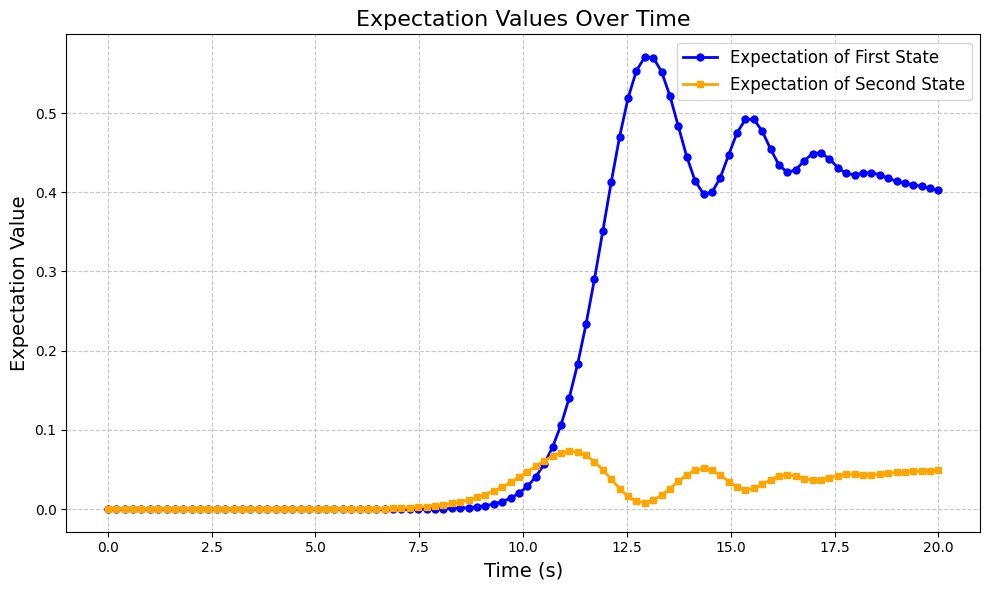

In [43]:
def Hamiltonian(t, args):
    """Construct the time-dependent Hamiltonian using the reduced Hamiltonians and parameters."""
    return Qobj(H_reduced0) * Omega(t, args) + Qobj(H_reducedp) * Delta(t, args)

# Prepare the time-dependent Hamiltonian representation
H_t_reduced = [[Qobj(H_reduced0), Omega], [Qobj(H_reducedp), Delta]]

# Initialize operators for expectation values
e_ops1 = np.zeros((len(all_independent_sets), len(all_independent_sets)))
e_ops1[0, 0] = 1  # Expectation operator for the first state
e_ops2 = np.zeros((len(all_independent_sets), len(all_independent_sets)))
e_ops2[1, 1] = 1  # Expectation operator for the second state

# Get the ground state of the Hamiltonian at the initial time
psi_re = Hamiltonian(taulist[0], args).groundstate()[1]

# Solve the master equation using mesolve
result = mesolve(
    H_t_reduced,
    psi_re,
    taulist,
    c_ops,
    [Qobj(e_ops1), Qobj(e_ops2)],
    args=args,
    options=Options(store_states=True)
)

# Plot the expectation values over time with enhanced aesthetics
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(result.times, result.expect[0], label='Expectation of First State', color='blue', linewidth=2, linestyle='-', marker='o', markersize=5)
plt.plot(result.times, result.expect[1], label='Expectation of Second State', color='orange', linewidth=2, linestyle='-', marker='s', markersize=5)

# Add labels and title
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Expectation Value', fontsize=14)
plt.title('Expectation Values Over Time', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid with a dashed line style and some transparency

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

## Torch usage - Unused

In [44]:
import scipy
import scipy.linalg
import random
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from tqdm import tqdm 
from time import perf_counter
from scipy.sparse.linalg import gmres
from multiprocessing import Process
# from qutip.fastsparse import csr2fast
import torch
import math 
import random
from torch import nn

# Ls_sparse = [(L.data.tocoo()) for L in c_ops]
# Ls = [(L.full()) for L in c_ops]
# non_herm = -1j/2 * sum([L.T.conjugate()@L for L in Ls])
# Ls_sparse = [
#     torch.sparse_coo_tensor(
#         indices=torch.tensor([coo.row, coo.col], dtype=torch.int64),
#         values=torch.tensor(coo.data, dtype=torch.float32),
#         size=coo.shape
#     ,dtype = torch.complex128)
#     for L in c_ops
#     for coo in [L.data.tocoo()]] # Convert QuTiP data to COO format

# Ls_sparse

In [45]:
def qobj_to_torch_sparse_COO(qobjs):
    torch_sparse_tensors = []
    for qobj in qobjs:
        # Extract the data from Qobj to csr_matrix
        csr = qobj.data  # This is already a csr_matrix
        # Extract coo_matrix for easier conversion
        coo = csr.tocoo()
        # Create indices and values for PyTorch sparse tensor
        indices = torch.LongTensor([coo.row, coo.col])
        values = torch.Tensor(coo.data.real) + 1j * torch.Tensor(coo.data.imag)
        # Create a sparse tensor in PyTorch
        shape = torch.Size(csr.shape)
        sparse_tensor = torch.sparse_coo_tensor(indices, values, shape, dtype=torch.complex128)
        torch_sparse_tensors.append(sparse_tensor)
    return torch_sparse_tensors



# def qobj_to_torch_sparse_CSR(qobjs):
#     torch_sparse_tensors = []
#     for qobj in qobjs:
#         # Extract the data from Qobj to csr_matrix
#         csr = qobj.data  # This is already a csr_matrix

#         # Extract the indices and values for PyTorch sparse tensor in CSR format
#         # The indices for CSR are slightly different as it uses compressed indices for rows
#         crow_indices = torch.tensor(csr.indptr, dtype=torch.long)  # Pointer to row indices
#         col_indices = torch.tensor(csr.indices, dtype=torch.long)  # Column indices
#         values = torch.tensor(csr.data.real, dtype=torch.float64) + 1j * torch.tensor(csr.data.imag, dtype=torch.float64)

#         # Create a sparse tensor in PyTorch using CSR format
#         shape = torch.Size(csr.shape)
#         sparse_tensor = torch.sparse_csr_tensor(crow_indices, col_indices, values, size=shape, dtype=torch.comple64)
        
#         torch_sparse_tensors.append(sparse_tensor)
#     return torch_sparse_tensors

#Ls_sparse_csr = qobj_to_torch_sparse_CSR(c_ops)
Ls_sparse_COO = qobj_to_torch_sparse_COO(c_ops)

#non_herm = -1j/2 * sum([L.T.conj().mm(L) for L in Ls_sparse])
#non_herm = -1j/2 *torch.sum(Ls_sparse)
# sparse_sum = Ls_sparse_csr[0]

# # Iterate and add each subsequent sparse tensor
# for tensor in Ls_sparse_COO[1:]:
#     sparse_sum -= 1j/2* tensor
#non_herm = -1j/2 * torch.sparse.addmm(Ls_sparse_csr[0], Ls_sparse_csr[1], beta=1., alpha=1.)

#sparse_sum
Ls = [(L.full()) for L in c_ops]
non_herm = -1j/2 * sum([L.T.conjugate()@L for L in Ls])
non_herm = torch.tensor(non_herm)




AttributeError: 'qutip.core.data.dense.Dense' object has no attribute 'tocoo'

In [39]:
taulist = torch.linspace(0, taumax, steps=100) 
nsteps = len(taulist)
dt = taulist[1]-taulist[0]

In [40]:
H_reducedp_tor = torch.from_numpy(H_reducedp)
H_reduced0_tor = torch.from_numpy(H_reduced0)

In [41]:

psi0 = torch.zeros(len(psi_re.full()),dtype=torch.complex128)
psi0[-1] = 1
target = torch.zeros(len(psi_re.full()),dtype=torch.complex128)
target[0] = 1
e_ops1 = torch.tensor(e_ops1,dtype=torch.complex128).to_sparse_coo()



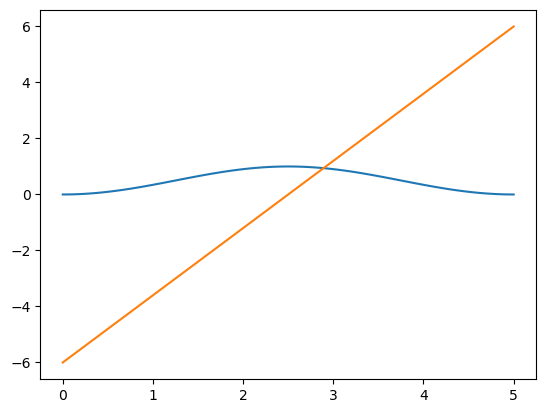

In [42]:
def Omega(t, args):
    return OMEGA_0 * torch.sin(torch.pi * t / args["t_max"]) ** 2

def Delta(t, args):
    return DELTA_0 * (2 * t / args["t_max"] - 1)

params = torch.tensor([Omega(t, args).item() for t in taulist],  dtype=torch.float32,requires_grad=True)


vec_delta = torch.tensor([Delta(t, args) for t in taulist], dtype=torch.float32)


plt.plot(taulist,params.detach().numpy())
plt.plot(taulist,vec_delta)




In [43]:
def compute_krylov_basis_orthogonal(A, b, m):
    A = A.to(torch.complex128).detach()  # Ensure A is detached if it does not need gradient tracking
    b = b.to(torch.complex128)

    beta = torch.linalg.norm(b)
    V = torch.zeros((len(b), m+1), dtype=torch.complex128)
    H = torch.zeros((m+1, m), dtype=torch.complex128)
    V[:, 0] = b / beta

    for j in range(m):
        w = torch.matmul(A, V[:, j]).clone()  # Clone to avoid any potential issues
        for i in range(j + 1):
            H[i, j] = torch.dot(V[:, i].conj(), w)
            w = w - H[i, j] * V[:, i]  # No inplace operation

        H[j + 1, j] = torch.linalg.norm(w)
        if H[j + 1, j].real < 1e-10 or j == m-1:
            return H[:j+1, :j+1], V[:, :j+1]
        V[:, j + 1] = w / H[j + 1, j]
    
    return H[:-1, :], V[:, :-1]


H = H_reduced0_tor * params[10] + H_reducedp_tor *vec_delta[10]
A = H + non_herm
v = psi0
k = 3


H,V = compute_krylov_basis_orthogonal(A, v, k)
#V.matmul(H.matmul(V.conj().T)).size()



4

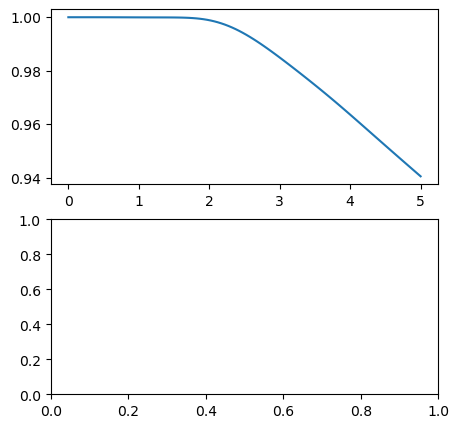

In [56]:

def Monte_Carlo_Improved_sampling(p,sample):
    mean = torch.zeros(len(taulist), dtype=torch.complex128)  # Array for the results
    for count in (range(sample)):
     
        
        waves = [psi0]
        for idx, t in enumerate(taulist[1:]):
            wave_last = waves[-1]
           
            u = random.uniform(p[-1], 1)
            H = H_reduced0_tor * params[idx] + H_reducedp_tor *vec_delta[idx]
            H_eff = H + non_herm
            num_L = len(Ls_sparse_COO)
            dps = torch.zeros(num_L, dtype=torch.float)
            for i in range(num_L):
              
                L = Ls_sparse_COO[i]

                # Perform matrix multiplication using PyTorch
                right = torch.matmul(L, wave_last)

                # Conjugate transpose and multiply
                left = right.T.conj()

                # Calculate dps
                dps[i] = torch.real(dt * torch.matmul(left, right))

            dP = torch.sum(dps).item()
          
            # Test and choose the path
            if dP < u:
                # Assuming Heff(t, args) returns a tensor and a method to compute expm is defined
                H,V  =  compute_krylov_basis_orthogonal( H_eff, wave_last, 7)
                exp = torch.matrix_exp( -1j * dt * H)
                #temp = V.matmul(exp.matmul(V.conj().T.matmul(wave_last)))
                step0 = V.conj().T
                step1 = step0.matmul(wave_last)
                step2 = exp.matmul(step1)
                temp = V.matmul(step2)
             

        
                #temp = torch.matmul(exp,wave_last)
                #exp = torch.matrix_exp(-1j * dt *H_eff)
                #temp = torch.matmul(exp,wave_last) 
                p[-1] = 0
                
                
               
            else:
                u = torch.rand(1).item()
                Q = torch.cumsum(dps, dim=0) / dP
                k = torch.searchsorted(Q, torch.tensor([u])).item()
                temp = torch.matmul(Ls_sparse_COO[k], wave_last)

                
                
            #print(temp.dtype)
            waves.append(temp / torch.norm(temp))
        #print(mean)
        # Compute expectation values
        mean += torch.stack([wave.T.conj().matmul(e_ops1.matmul(wave)) for wave in waves])

    mean /= sample
    return mean, waves



def Non_Jump_trajectory(params, vec_delta, psi0, times, dt):
#    device = params.device  # Ensure calculations are performed on the same device as params

    p_vec = [torch.norm(psi0)]
    waves = [psi0]
    for idx, t in enumerate(times[1:]):
        wave_last = waves[-1]
        H= H_reduced0_tor * params[idx] + H_reducedp_tor *vec_delta[idx]
        H_eff = H + non_herm
        # Use a more efficient method for expm if available
        #H,V  =  compute_krylov_basis_orthogonal( H_eff, wave_last, 5)
        #exp = torch.matrix_exp( -1j * dt * H_eff)
        #temp = V.matmul(exp.matmul(V.conj().T.matmul(wave_last)))
        #step0 = V.conj().T
        #step1 = step0.matmul(wave_last)
        #step2 = exp.matmul(step1)
        #temp = V.matmul(step2)
        
        expm_H_eff_dt = torch.matrix_exp(-1j * H_eff * dt)
        
        temp = torch.matmul(expm_H_eff_dt,waves[-1])
        p_vec.append(torch.norm(temp))
        
        waves.append(temp)
    return p_vec,waves


p, waves = Non_Jump_trajectory(params, vec_delta, psi0, taulist, dt)

fig, axs = plt.subplots(2, 1, figsize=(5, 5))  # Creates a figure and 2 subplots

# # Subplot 1: norm vs. Time
axs[0].plot(taulist[:], torch.tensor(p).detach().numpy())
m_tot = 55
m_sim = math.ceil((1-p[-1]) * m_tot)

m_sim

In [48]:
mean1,_ =  Monte_Carlo_Improved_sampling(p,m_sim)

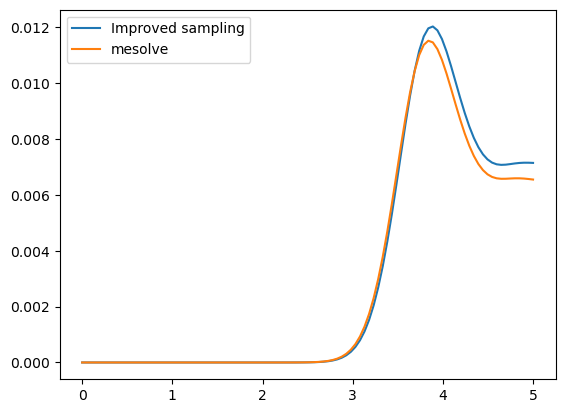

In [49]:
plt.plot(taulist,mean1.detach().numpy(),label = 'Improved sampling')
plt.plot(taulist,result.expect[0],label = 'mesolve')
plt.legend()
plt.show()
# plt.plot(taulist[:],torch.tensor(p).detach().numpy(),label = 'norm')
# #plt.ylim(0,1.5)
# torch.tensor(p[-1])

In [50]:
from line_profiler import LineProfiler

def main():
    # Assuming these variables are defined properly: params, vec_delta, Ls, psi0, e_ops, times, dt, sample
    Monte_Carlo_Improved_sampling(p,1)

lp = LineProfiler()
lp.add_function(Monte_Carlo_Improved_sampling)  # Add the specific function to profile
lp_wrapper = lp(main)
lp_wrapper()
lp.print_stats()  # Print the profiling results


Timer unit: 1e-09 s

Total time: 2.94456 s
File: /var/folders/lf/__6nzt_j7mqfqhn_dprjx0jh0000gn/T/ipykernel_884/2750371512.py
Function: main at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def main():
     4                                               # Assuming these variables are defined properly: params, vec_delta, Ls, psi0, e_ops, times, dt, sample
     5         1 2944564000.0    3e+09    100.0      Monte_Carlo_Improved_sampling(p,1)

Total time: 2.81754 s
File: /var/folders/lf/__6nzt_j7mqfqhn_dprjx0jh0000gn/T/ipykernel_884/816187563.py
Function: Monte_Carlo_Improved_sampling at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def Monte_Carlo_Improved_sampling(p,sample):
     2         1     101000.0 101000.0      0.0      mean = torch.zeros(len(taulist), dtype=torch.complex128)  # Array for the results
     3         2       5000.0   

In [51]:
def batch_data(n):
    data = []
    #print(p[-1],'out')
    for _ in range(n):
        #print(p[-1],'in')
        clone_p = torch.tensor(p).clone()
        _,stor_wave =  Monte_Carlo_Improved_sampling(clone_p,1)
        data.append(stor_wave[-1])
    data_tensor = torch.stack(data)  # This stacks the tensors along a new dimension (0 by default)

# Now calculate the mean along the 0th dimension (element-wise average across all tensors)
    elementwise_mean = data_tensor.mean(dim=0)

    return elementwise_mean

In [52]:
def infidelity(psi, target):
    # Assuming psi and target are normalized
    fidelity = torch.abs(torch.dot(psi.conj().T, target))**2
    return 1-fidelity



def First_Der(params):
    first_derivative = torch.diff(params, dim=0)
    derivative_penalty = torch.sum(first_derivative ** 2)
    return derivative_penalty


def Second_Der(params):
   first_derivative = torch.diff(params, dim=0)
   second_derivative = torch.diff(first_derivative, dim=0)
   sec_derivative_penalty = torch.sum(second_derivative ** 2)


   return sec_derivative_penalty



def Pulse_power(params):
    return torch.sum(torch.abs(params)**2)



def Positivity(params):
    pos = [torch.abs(param)-param for param in params]
    return dt * sum(pos)



def Gaussian_Envelope(params):
    # Assuming vec_omega is defined, with shape [num_time_points]
    num_time_points = len(vec_omega)
    time_indices = torch.arange(num_time_points).float()

    # Define parameters for the target Gaussian envelope
    A = 1.0  # Amplitude
    mu = num_time_points / 2  # Mean, placing the center of the Gaussian at the middle of the pulse duration
    sigma = num_time_points / 7  # Standard deviation, controlling the width of the Gaussian

    # Define the target Gaussian profile
    target_gaussian =  torch.exp(-0.5 * ((time_indices - mu) ** 2) / (sigma ** 2))
    target_gaussian = target_gaussian/(sigma * np.sqrt(2*np.pi))


    deviation = torch.abs(params-params *target_gaussian )**2
    return torch.sum(deviation)





def loss_function(psi,params,target):



    return infidelity(psi, target)+0.1 * First_Der(params)+0.000001 * Second_Der(params)+ 0.000001 * Pulse_power(params)+Positivity(params)



In [53]:

num_epochs = 5000
loss_threshold = 0.01
#0.5 lead to convg


optimizer = torch.optim.Adam([params], lr=.06)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.3)
#torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose='deprecated')

loss = []
infid = []
ep = []

# num_epochs is the number of iterations you want to run the optimization for

for epoch in range(num_epochs): 
     
     optimizer.zero_grad()   
     
     # calculate the norm of non jump trajectory
     p, waves =  Non_Jump_trajectory(params, vec_delta, psi0, taulist, dt)
     
     non_jump_loss = loss_function(waves[-1],params,target)

     # calculate the norm of non jump trajectory

     m_sim = math.ceil((1-p[-1]) * m_tot)
     
     #calculate the average wave function after m similations 
     avg_Psi_N  = batch_data(m_sim)
     jump_loss = loss_function(avg_Psi_N,params,target)
   
     net_loss = non_jump_loss*p[-1] + (1-p[-1])*jump_loss

   
     net_loss.backward()

    #  #inforce zero at the edges
     params.grad[0] = 0
     params.grad[-1] = 0
     
     
     

     #update
     optimizer.step()

     #if epoch % 10 == 0:  # Print the loss every 10 epochs
     psi_avg_tot = 1/2 * (avg_Psi_N+waves[-1])
     tot_infid = infidelity(psi_avg_tot,target)
     print(f"Epoch {epoch}, loss: {net_loss.item()}, infidelity: {tot_infid}")
     loss.append(net_loss.item())
     infid.append(tot_infid)
     ep.append(epoch)
        
     if tot_infid< loss_threshold:
        print(f"Stopping early at epoch {epoch} , infidelity: {infidelity(avg_Psi_N,target)}.")
        break

Epoch 0, loss: 0.9986201559003932, infidelity: 0.9952897251663323
Epoch 1, loss: 0.9940423673162739, infidelity: 0.9809862459050769
Epoch 2, loss: 0.9824483960099296, infidelity: 0.9617559274262758
Epoch 3, loss: 0.976859090678993, infidelity: 0.9375350950031768
Epoch 4, loss: 0.9626520078629514, infidelity: 0.9353297098169395
Epoch 5, loss: 0.9503763814956215, infidelity: 0.896983494489445
Epoch 6, loss: 0.9377366401922839, infidelity: 0.9123221588631207
Epoch 7, loss: 0.9164150505429998, infidelity: 0.8758603975640877
Epoch 8, loss: 0.9082887073208172, infidelity: 0.8697942568377918
Epoch 9, loss: 0.9052653643945943, infidelity: 0.865459945082212
Epoch 10, loss: 0.9019042998326268, infidelity: 0.8618468221203363
Epoch 11, loss: 0.897267927020823, infidelity: 0.8581556928027814
Epoch 12, loss: 0.8964520207965393, infidelity: 0.8978226239913938
Epoch 13, loss: 0.8894158714504492, infidelity: 0.8855760178947643
Epoch 14, loss: 0.8796195802975071, infidelity: 0.8440362965378576


KeyboardInterrupt: 

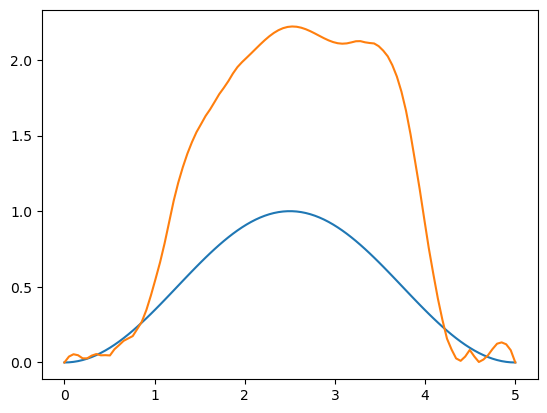

In [62]:

def Omega(t, args):
    return Omega_0 * torch.sin(torch.pi * t / args["t_max"]) ** 2


plt.plot(taulist,Omega(taulist,args))
plt.plot(taulist,params.detach().numpy())

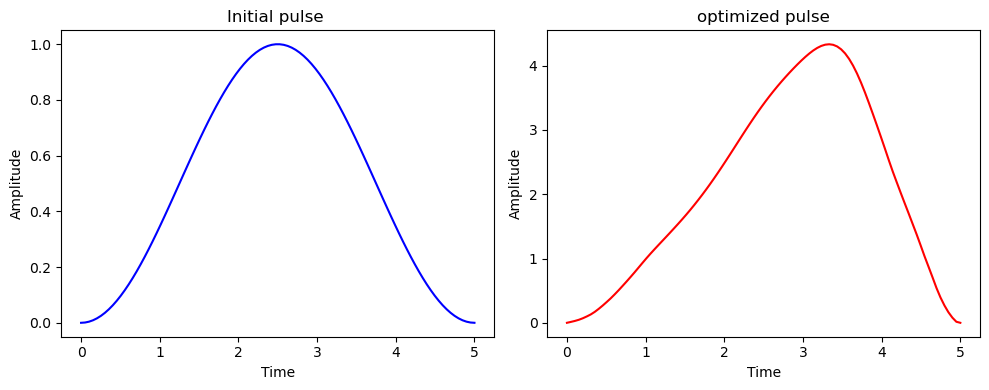

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot on the first axis
axs[0].plot(taulist, Omega(taulist,args), 'b-')  # 'b-' is a blue line
axs[0].set_title('Initial pulse ')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')

# Plot on the second axis
axs[1].plot(taulist,params.detach().numpy(), 'r-')  # 'r-' is a red line
axs[1].set_title('optimized pulse')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')

# Display the plot
plt.tight_layout()  # Adjusts plot parameters to give specified padding
plt.show()

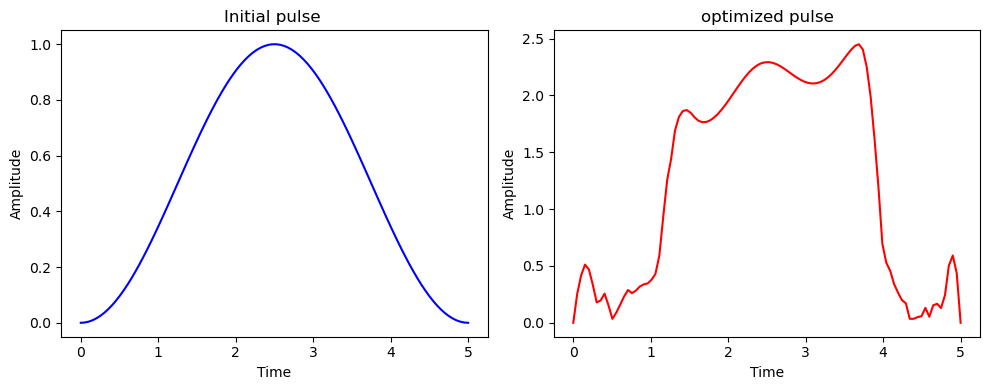

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot on the first axis
axs[0].plot(taulist, Omega(taulist,args), 'b-')  # 'b-' is a blue line
axs[0].set_title('Initial pulse ')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')

# Plot on the second axis
axs[1].plot(taulist,params.detach().numpy(), 'r-')  # 'r-' is a red line
axs[1].set_title('optimized pulse')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')

# Display the plot
plt.tight_layout()  # Adjusts plot parameters to give specified padding
plt.show()

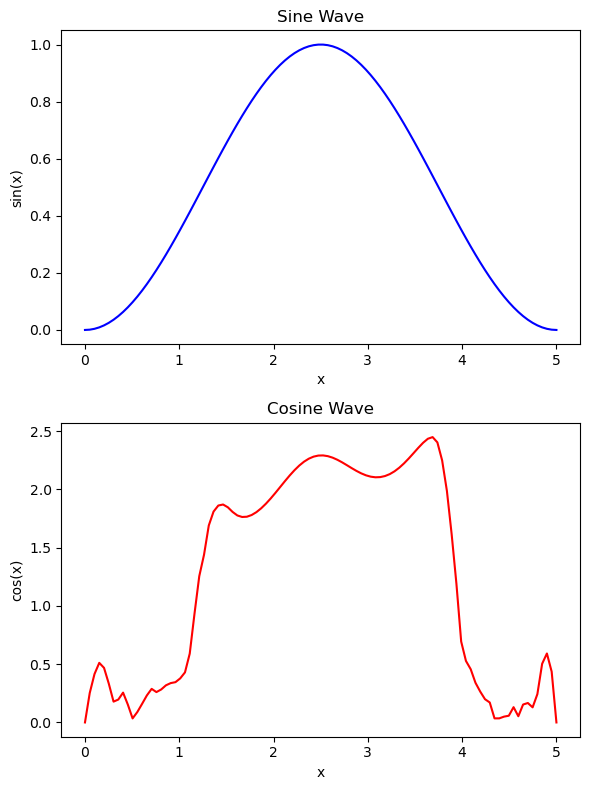

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8))  # 2 rows, 1 column

# Plot on the first axis
axs[0].plot(taulist, Omega(taulist,args), 'b-')
axs[0].set_title('Sine Wave')
axs[0].set_xlabel('x')
axs[0].set_ylabel('sin(x)')

# Plot on the second axis
axs[1].plot(taulist,params.detach().numpy(), 'r-')
axs[1].set_title('Cosine Wave')
axs[1].set_xlabel('x')
axs[1].set_ylabel('cos(x)')

# Display the plot
plt.tight_layout()
plt.show()

In [109]:
# import torch

# def arnoldi_iteration(A, v, k):
#     """
#     Perform k steps of the Arnoldi iteration on matrix A with initial vector v.
    
#     Args:
#     A (torch.Tensor): The input matrix A.
#     v (torch.Tensor): Initial vector v, which must be non-zero.
#     k (int): Number of iterations to perform, usually k << A.shape[0].
    
#     Returns:
#     Q (torch.Tensor): Orthonormal basis for the Krylov subspace.
#     H (torch.Tensor): Upper Hessenberg matrix representing the reduced system.
#     """
#     n = A.shape[0]
#     Q = torch.zeros((n, k), dtype=A.dtype, device=A.device)
#     H = torch.zeros((k, k), dtype=A.dtype, device=A.device)
#     Q[:, 0] = v / torch.norm(v)  # Normalize the initial vector
    
#     for j in range(k):
#         q = A @ Q[:, j]  # Apply the matrix A
        
#         # Orthogonalize against all previous vectors
#         for i in range(j + 1):
#             H[i, j] = torch.dot(Q[:, i], q)
#             q = q - H[i, j] * Q[:, i]
        
#         if j + 1 < k:
#             H[j + 1, j] = torch.norm(q)
#             if torch.abs(H[j + 1, j])**2 > 0:  # Avoid division by zero
#                 Q[:, j + 1] = q / H[j + 1, j]
    
#     return Q, H

# # Example usage:
# H = H_reduced0_tor * params[100] + H_reducedp_tor *vec_delta[100]
# A = H + non_herm
# #A = torch.randn(5, 5)  # Random 5x5 matrix
# v = psi0   # Random initial vector
# k = 5   # Number of Krylov subspace dimensions to compute

# Q, H = arnoldi_iteration(A, v, k)
# print("Q (orthonormal basis of Krylov subspace):\n", Q)
# print("H (upper Hessenberg matrix):\n", H)


In [110]:
# Qobj(H.detach().numpy() ) 

In [111]:
# Q.matmul(torch.linalg.matrix_exp(H).matmul(Q.conj().T))

In [58]:
psi0.size()

torch.Size([233])

In [38]:
infid

[tensor(0.7971, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.7082, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.6189, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.5186, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.4743, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.4018, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.3927, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.3673, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.3753, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.4085, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.3620, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.3912, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.3591, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.3330, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.2637, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor(0.3047, dtype=torch.float64, grad_fn=<RsubBackw

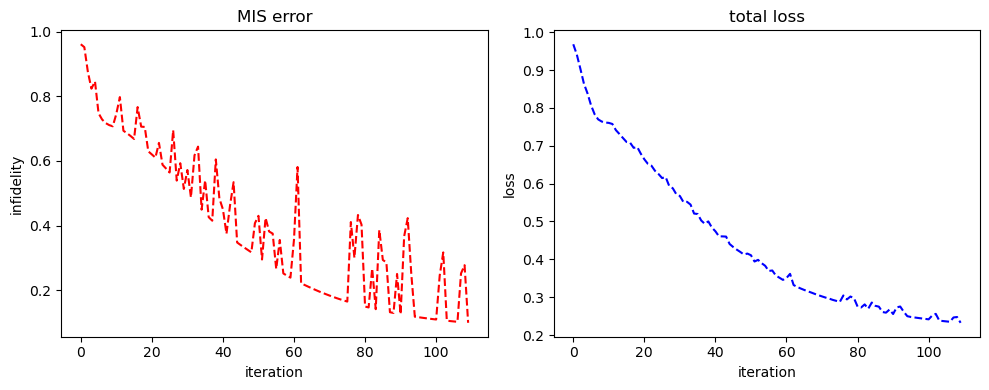

In [26]:




fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot on the first axis
axs[0].plot(ep,torch.tensor(infid).detach().numpy(),'r--',label = 'infidelity')  # 'b-' is a blue line
axs[0].set_title('MIS error')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('infidelity')

# Plot on the second axis
axs[1].plot(ep,torch.tensor(loss).detach().numpy(),'b--',label = 'total loss')  # 'r-' is a red line
axs[1].set_title('total loss')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')

# Display the plot
plt.tight_layout()  # Adjusts plot parameters to give specified padding
plt.show()

In [115]:
import torch

# Example of real-valued signal
real_signal = torch.randn(10)  # A random real tensor
fft_of_real = torch.fft.fft(real_signal)

# Example of complex-valued signal
complex_signal = torch.randn(10) + 1j * torch.randn(10)  # A random complex tensor
fft_of_complex = torch.fft.fft(complex_signal)

print("FFT of real-valued signal:", fft_of_real)
print("FFT of complex-valued signal:", fft_of_complex)


FFT of real-valued signal: tensor([ 2.2232+0.0000j,  1.4899-2.4171j, -0.6565+1.9922j, -3.6792-1.4946j,
        -0.8604+1.5721j, -0.6516+0.0000j, -0.8604-1.5721j, -3.6792+1.4946j,
        -0.6565-1.9922j,  1.4899+2.4171j])
FFT of complex-valued signal: tensor([-0.5854-0.6003j, -5.4789-1.1237j,  1.0818-2.0793j,  2.5010+1.1970j,
        -3.0698+2.1111j, -3.1026+0.3547j,  2.3423-3.6554j, -0.3647+3.1575j,
        -3.3191-1.5773j, -2.5855+4.7361j])


In [118]:
H_reduced0_tor

tensor([[0.0000, 0.5000, 0.0000, 0.5000, 0.0000],
        [0.5000, 0.0000, 0.0000, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5000],
        [0.5000, 0.0000, 0.0000, 0.0000, 0.5000],
        [0.0000, 0.5000, 0.5000, 0.5000, 0.0000]], dtype=torch.float64)

In [21]:
pip install arpack

ERROR: Could not find a version that satisfies the requirement arpack (from versions: none)
ERROR: No matching distribution found for arpack
Note: you may need to restart the kernel to use updated packages.
